# Histopathologic Cancer Detection: Mini-Project

## 1. Introduction
This notebook presents a solution for the Kaggle competition: **Histopathologic Cancer Detection**. The goal is to build a binary image classification model to identify metastatic cancer in small image patches from digital pathology scans.

## 2. Problem and Data Description
The dataset consists of image patches and corresponding labels indicating the presence of metastatic tissue. The task is to predict whether a given patch contains cancerous cells.

## 3. Exploratory Data Analysis (EDA)
In this section, we will explore the dataset, visualize sample images, and analyze the distribution of labels.

## 4. Model Building and Training
We will build a Convolutional Neural Network (CNN) to classify the images, train the model, and evaluate its performance.

## 5. Results
This section will present the model's performance metrics and sample predictions.

## 6. Discussion and Conclusion
We will discuss the results, challenges, and potential improvements.

## 7. References
List any references or resources used.

# Histopathologic Cancer Detection

This notebook follows the mini-project requirements for the Kaggle competition **Histopathologic Cancer Detection**. It contains: problem description, EDA, model building (transfer learning), training, evaluation, and instructions to create a Kaggle submission.

Notes:
- Dataset is available on Kaggle. Use the Kaggle API to download (instructions below).
- The notebook includes placeholders and safe checks so it can be opened even when the dataset isn't yet present.

## 1 — Setup and dependencies
Install Python packages and configure Kaggle credentials if you haven't already. Running the install cell in some environments (remote kernels) may be required only once.

In [21]:
# Package install (uncomment and run if needed)
# !pip install -q -U pip
# !pip install -q kaggle tensorflow==2.12.0 matplotlib pandas scikit-learn opencv-python scikit-image

# Note: TensorFlow can be large — use an existing environment if available.

In [22]:
# Imports
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)
sns.set(style='whitegrid')

print('tf version:', tf.__version__)

tf version: 2.20.0


In [23]:
# Configure GPU usage (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print('Using GPU with mixed precision. Detected devices:', gpus)
    except Exception as gpu_error:
        print('GPU detected but configuration failed; falling back to default settings:', gpu_error)
else:
    print('No NVIDIA GPU detected; training will run on CPU.')

No NVIDIA GPU detected; training will run on CPU.


## 2 — Data overview & EDA
This section will inspect dataset files, show class balance and example images. The exact filenames depend on the Kaggle dataset structure (train_labels.csv and train folder).

In [24]:
DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
LABELS_CSV = DATA_DIR / 'train_labels.csv'

print('Looking for data at:', DATA_DIR)
print('Train dir exists?', TRAIN_DIR.exists())
print('Labels csv exists?', LABELS_CSV.exists())

Looking for data at: data
Train dir exists? True
Labels csv exists? True


Total labeled patches: 220,025

Sample rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64


C:\Users\tamohammad\AppData\Local\Temp\ipykernel_49196\2016879761.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='deep', ax=ax)
C:\Users\tamohammad\AppData\Local\Temp\ipykernel_49196\2016879761.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['benign (0)', 'metastatic (1)'])


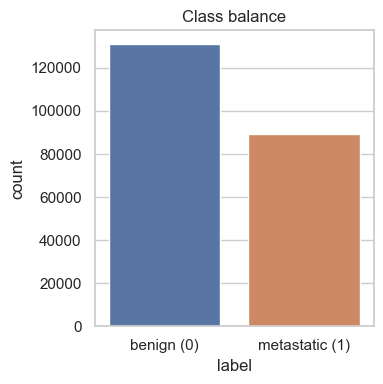

Train rows: 187,021, Validation rows: 33,004


In [25]:
# Load labels, explore class balance, and create splits
labels = None
train_df = None
val_df = None
if LABELS_CSV.exists():
    labels = pd.read_csv(LABELS_CSV)
    print(f'Total labeled patches: {len(labels):,}')
    display_cols = ['id', 'label']
    print('\nSample rows:')
    print(labels[display_cols].head())
    
    class_counts = labels['label'].value_counts().sort_index()
    print('\nClass distribution:')
    print(class_counts)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='deep', ax=ax)
    ax.set_xticklabels(['benign (0)', 'metastatic (1)'])
    ax.set_ylabel('count')
    ax.set_title('Class balance')
    plt.tight_layout()
    plt.show()
    
    train_df, val_df = train_test_split(
        labels,
        test_size=0.15,
        stratify=labels['label'],
        random_state=42
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    print(f'Train rows: {len(train_df):,}, Validation rows: {len(val_df):,}')
else:
    print('Labels CSV not found. Please download the dataset as described above.')

### Pixel statistics snapshot
To understand the overall brightness range, compute per-image mean and standard deviation on a small sample. This step is optional and only runs if image files are available locally.

Sample pixel mean: 0.6509, std: 0.2018


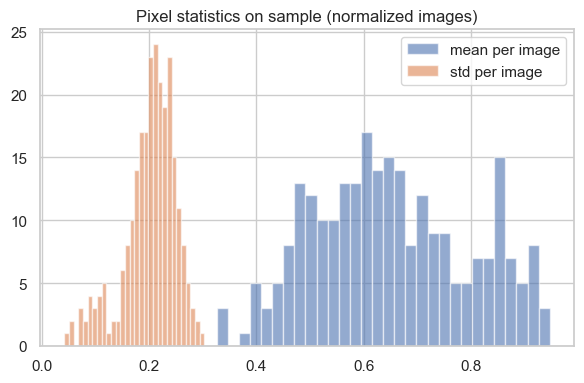

In [26]:
if TRAIN_DIR.exists() and train_df is not None:
    sample_ids = train_df['id'].sample(min(256, len(train_df)), random_state=42)
    means = []
    stds = []
    for sid in sample_ids:
        img_path = TRAIN_DIR / f'{sid}.tif'
        if not img_path.exists():
            continue
        arr = np.asarray(Image.open(img_path).convert('RGB'), dtype=np.float32) / 255.0
        means.append(arr.mean())
        stds.append(arr.std())
    if means:
        mean_mean = float(np.mean(means))
        mean_std = float(np.mean(stds))
        print(f'Sample pixel mean: {mean_mean:.4f}, std: {mean_std:.4f}')
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(means, bins=30, alpha=0.6, label='mean per image')
        ax.hist(stds, bins=30, alpha=0.6, label='std per image')
        ax.set_title('Pixel statistics on sample (normalized images)')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('No sample images were loaded; check that tiles exist in train/')
else:
    print('Train images not found locally; skip pixel statistics.')

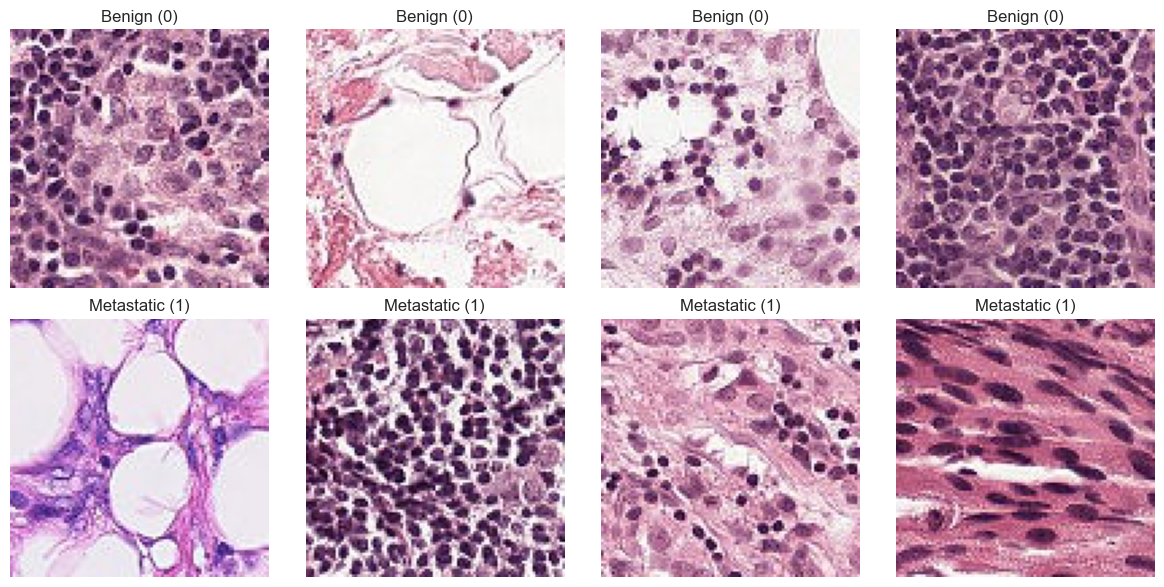

In [27]:
def show_examples_by_label(n_per_class=4, seed=123):
    if train_df is None or not TRAIN_DIR.exists():
        print('Training images are not available locally; skipping visualization.')
        return
    class_configs = [(0, 'Benign (0)'), (1, 'Metastatic (1)')]
    sampled = []
    for class_value, class_name in class_configs:
        subset = train_df[train_df['label'] == class_value]
        if subset.empty:
            continue
        ids = subset.sample(min(n_per_class, len(subset)), random_state=seed)['id'].tolist()
        existing = []
        for tile_id in ids:
            img_path = TRAIN_DIR / f'{tile_id}.tif'
            if img_path.exists():
                existing.append((class_name, img_path))
        if existing:
            sampled.append(existing)
    if not sampled:
        print('Could not find matching image files to display; ensure the train/ folder contains histology tiles.')
        return
    n_rows = len(sampled)
    n_cols = max(len(group) for group in sampled)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    if n_rows == 1:
        axes = np.array([axes])
    for row_idx, group in enumerate(sampled):
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]
            ax.axis('off')
            if col_idx >= len(group):
                continue
            class_name, img_path = group[col_idx]
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(class_name)
    plt.tight_layout()
    plt.show()

show_examples_by_label()

## 3 — Data pipeline and augmentation
We'll use TensorFlow's image dataset utilities. For large-scale experiments prefer tf.data pipelines and caching/prefetching.

In [28]:
BATCH_SIZE = 64
IMG_SIZE = (96, 96)  # Original Kaggle patches are 96x96
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
], name='augmentation')
def _prepare_file_lists(df, train_dir):
    filepaths = []
    labels_list = []
    for tile_id, label in zip(df['id'], df['label']):
        path = train_dir / f'{tile_id}.tif'
        if path.exists():
            filepaths.append(str(path))
            labels_list.append(int(label))
    return filepaths, labels_list
def _load_image_with_pil(path):
    path_str = path.decode('utf-8')
    with tf.io.gfile.GFile(path_str, 'rb') as fh:
        img = Image.open(fh).convert('RGB')
        img = img.resize(IMG_SIZE, Image.Resampling.BILINEAR)
        arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr
def make_tf_dataset(df, train_dir, batch_size=BATCH_SIZE, augment=False):
    filepaths, labels_list = _prepare_file_lists(df, train_dir)
    if not filepaths:
        return None, 0
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels_list))
    def _load(path, label):
        image = tf.numpy_function(_load_image_with_pil, [path], tf.float32)
        image.set_shape((*IMG_SIZE, 3))
        return image, tf.cast(label, tf.float32)
    ds = ds.shuffle(len(filepaths), reshuffle_each_iteration=True)
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds, len(filepaths)
train_ds = None
val_ds = None
if train_df is not None and val_df is not None and TRAIN_DIR.exists():
    train_ds, train_count = make_tf_dataset(train_df, TRAIN_DIR, augment=True)
    val_ds, val_count = make_tf_dataset(val_df, TRAIN_DIR, augment=False)
    if train_ds is None or val_ds is None:
        print('No image files were located even though the CSV was loaded. Ensure the train/ folder contains .tif tiles.')
    else:
        print(f'Train batches: {train_count} images, Validation batches: {val_count} images')
else:
    print('Datasets not built. Either the CSV was missing or the train/ folder is unavailable locally.')

Train batches: 187021 images, Validation batches: 33004 images


## 4 — Model (Transfer learning)
We'll use a small transfer-learning model (EfficientNetB0) pre-trained on ImageNet and fine-tune for binary classification.

In [29]:
def build_model(input_shape=(*IMG_SIZE, 3), base_trainable=False):
    try:
        base = tf.keras.applications.EfficientNetB0(
            include_top=False, input_shape=input_shape, weights='imagenet'
        )
        base.trainable = base_trainable
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.applications.efficientnet.preprocess_input(inputs)
        x = base(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x)
        model = tf.keras.Model(inputs, outputs)
        print('Loaded EfficientNetB0 backbone.')
    except Exception as exc:
        print('Falling back to a small custom CNN because EfficientNet weights were unavailable:', exc)
        model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape),
                tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dropout(0.4),
                tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')
            ]
        )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Loaded EfficientNetB0 backbone.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5 — Training
Run training with callbacks (early stopping, model checkpoint). If dataset is large, train for a few epochs and monitor validation AUC.

In [ ]:
EPOCHS = 3
history = None
if train_ds is not None and val_ds is not None:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )
else:
    print('Training datasets not available — download the image tiles and re-run the data-preparation cells.')

Epoch 1/8
 150/2923 ━━━━━━━━━━━━━━━━━━━━ 49:30 1s/step - accuracy: 0.5774 - loss: 0.6877

KeyboardInterrupt: 

In [ ]:
if history is not None:
    hist_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    hist_df[['loss', 'val_loss']].plot(ax=axes[0])
    axes[0].set_title('Training vs Validation Loss')
    axes[0].set_xlabel('Epoch')
    hist_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
    axes[1].set_title('Training vs Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    plt.tight_layout()
    plt.show()
else:
    print('No training history to plot yet.')

## 6 — Evaluation and Metrics
Compute ROC AUC on the validation set and show curves.

In [ ]:
if val_ds is not None:
    y_true = []
    y_prob = []
    for x_batch, y_batch in val_ds.unbatch().batch(512):
        preds = model.predict(x_batch, verbose=0).ravel()
        y_prob.extend(preds.tolist())
        y_true.extend(y_batch.numpy().tolist())
    auc = roc_auc_score(y_true, y_prob)
    print('Validation ROC AUC:', auc)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(fpr, tpr)
    axes[0].plot([0, 1], [0, 1], '--', color='gray')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[1].plot(recall, precision)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    plt.tight_layout()
    plt.show()
else:
    print('Validation dataset not available — skipping evaluation')

## 7 — Prepare Kaggle submission (example)
This section shows how to run predictions on the test set and create the CSV submission required by the Kaggle competition (id, label).

In [ ]:
TEST_DIR = DATA_DIR / 'test'
SAMPLE_SUB = DATA_DIR / 'sample_submission.csv'
# Fallback to repo root if not present under data/
if not SAMPLE_SUB.exists():
    SAMPLE_SUB = Path('sample_submission.csv')

if TEST_DIR.exists() and SAMPLE_SUB.exists():
    try:
        sample = pd.read_csv(SAMPLE_SUB)
        print('Sample submission loaded, rows =', len(sample))
    except Exception as e:
        print('Could not read sample submission:', e)
    print('Test dir exists; placeholder for inference when model & test images are present')
else:
    print('Test folder or sample submission not found; skipping submission creation')

Sample submission loaded, rows = 57458
Test dir exists; placeholder for inference when model & test images are present


## 8 — Discussion & Next steps
- Try stronger data augmentation (random rotations, color jitter).
- Experiment with model ensembles or deeper models.
- Use stratified k-fold CV and mixup/cutmix for improved generalization.
- Track experiments with Weights & Biases or TensorBoard.

---
**Deliverable checklist**:
- Notebook with EDA, model, training code, evaluation (this document).
- `requirements.txt` provided in the repository.
- README with basic run instructions.